# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers import SimpleRNN, LSTM, SimpleRNNCell, GRU

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2022-11-07 14:08:57--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 142.250.145.139, 142.250.145.113, 142.250.145.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.145.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pfkib1dlq9ggn1ijivj7covru7f6jvhf/1667830125000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=25e33e3e-497d-4966-af4b-0a9ec11b935f [following]
--2022-11-07 14:08:58--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pfkib1dlq9ggn1ijivj7covru7f6jvhf/1667830125000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=25e33e3e-497d-4966-af4b-0a9ec11b935f
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 142.251.31.132, 2

In [ ]:
airline_passengers_data = pd.read_csv('/content/airline-passengers.csv')

In [ ]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

Распарсим дату

In [ ]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [ ]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [ ]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

Отбросим первый столбец, т.к. признаки [year, mon] его представляют.

In [ ]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Разбиваем выборку на обучение и на тест.

In [ ]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

Создаем данные для обучения

In [ ]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [ ]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [ ]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [ ]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

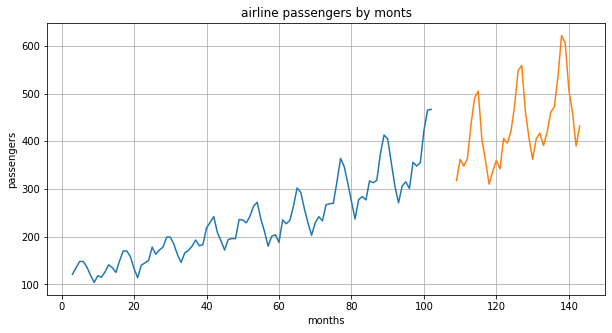

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [ ]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [ ]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [ ]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-traina

In [ ]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 9s 37ms/step - loss: 57290.8672 - mae: 226.5396 - val_loss: 196553.8750 - val_mae: 436.0406
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 56424.6367 - mae: 224.7054 - val_loss: 193308.3281 - val_mae: 432.3786
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 56025.5977 - mae: 224.3260 - val_loss: 189961.6562 - val_mae: 428.5723
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 55344.7969 - mae: 223.4469 - val_loss: 184546.1250 - val_mae: 422.3321
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 53832.4648 - mae: 221.2161 - val_loss: 173730.1719 - val_mae: 409.5570
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 50274.5820 - mae: 215.3947 - val_loss: 151518.4844 - val_mae: 381.9100
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 42168.6289 - mae: 199.9409 - val_loss: 109481.1094 - val_mae: 3

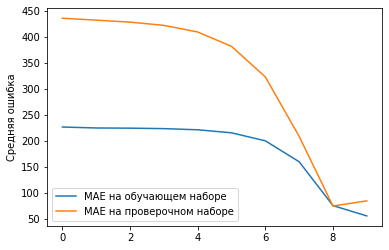

In [ ]:
plt.plot(history_1.history['mae'][:],
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:],
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [ ]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 1735.3494 - mae: 32.3687 - val_loss: 20729.8047 - val_mae: 125.1677
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 1213.9331 - mae: 27.3099 - val_loss: 13429.5107 - val_mae: 95.1101
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 1368.0408 - mae: 29.8650 - val_loss: 11862.4844 - val_mae: 87.9347
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 1242.3390 - mae: 28.3247 - val_loss: 12946.4775 - val_mae: 93.8924
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 1157.3636 - mae: 27.1899 - val_loss: 12248.6230 - val_mae: 90.5952
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 1112.7236 - mae: 26.4645 - val_loss: 11788.1279 - val_mae: 88.4948
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 1057.6968 - mae: 25.7823 - val_loss: 11500.9961 - val_mae: 87.3916
Epoch 8/10
13/13 [=

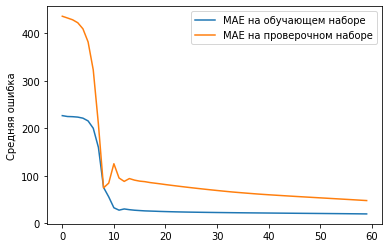

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 568.7098 - mae: 19.2711 - val_loss: 3963.3433 - val_mae: 46.9216
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 561.5574 - mae: 19.1462 - val_loss: 3877.2463 - val_mae: 46.3361
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 554.2115 - mae: 19.0161 - val_loss: 3792.2471 - val_mae: 45.7436
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 546.6610 - mae: 18.8804 - val_loss: 3708.3164 - val_mae: 45.1435
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 538.8960 - mae: 18.7407 - val_loss: 3625.4316 - val_mae: 44.5354
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 530.9061 - mae: 18.5978 - val_loss: 3543.5774 - val_mae: 43.9187
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 522.6825 - mae: 18.4481 - val_loss: 3462.7512 - val_mae: 43.3292
Epoch 8/10
13/13 [================

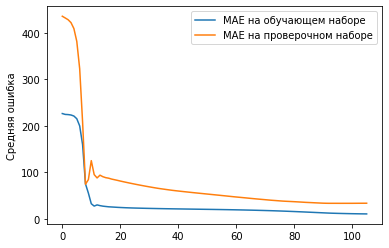

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 164.6138 - mae: 10.3956 - val_loss: 1624.5870 - val_mae: 33.5222
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 161.8651 - mae: 10.3180 - val_loss: 1623.3860 - val_mae: 33.5445
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 159.2983 - mae: 10.2399 - val_loss: 1623.3474 - val_mae: 33.5649
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 156.9456 - mae: 10.1677 - val_loss: 1623.9243 - val_mae: 33.5797
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 154.7104 - mae: 10.0935 - val_loss: 1625.4977 - val_mae: 33.5971
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 152.6806 - mae: 10.0247 - val_loss: 1627.0604 - val_mae: 33.6156
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 150.6910 - mae: 9.9503 - val_loss: 1629.8037 - val_mae: 33.6371
Epoch 2/10
13/13 [=================

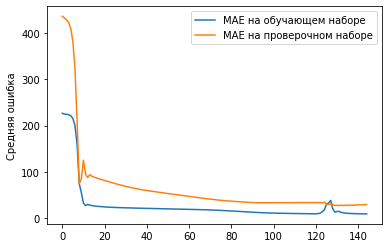

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 129.6178 - mae: 9.1651 - val_loss: 1194.9952 - val_mae: 29.4451
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 128.4575 - mae: 9.1126 - val_loss: 1205.3351 - val_mae: 29.5630
Epoch 3/10
13/13 [==============================] - 0s 30ms/step - loss: 127.1607 - mae: 9.0703 - val_loss: 1216.6257 - val_mae: 29.7066
Epoch 4/10
13/13 [==============================] - 0s 28ms/step - loss: 126.1171 - mae: 9.0179 - val_loss: 1226.0586 - val_mae: 29.8441
Epoch 5/10
13/13 [==============================] - 0s 31ms/step - loss: 125.1375 - mae: 8.9814 - val_loss: 1236.6050 - val_mae: 29.9826
Epoch 6/10
13/13 [==============================] - 0s 18ms/step - loss: 124.1547 - mae: 8.9339 - val_loss: 1246.6923 - val_mae: 30.1065
Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 123.3839 - mae: 8.8953 - val_loss: 1255.3027 - val_mae: 30.2053
Epoch 2/10
13/13 [=======================

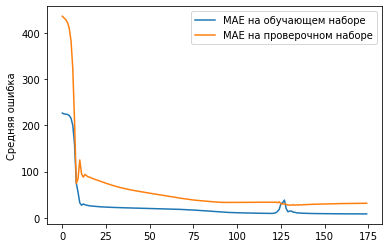

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 112.5834 - mae: 8.4307 - val_loss: 1367.4359 - val_mae: 31.5449
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 112.2302 - mae: 8.4195 - val_loss: 1375.7957 - val_mae: 31.6959
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 112.0193 - mae: 8.4042 - val_loss: 1373.8674 - val_mae: 31.6943
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 111.8040 - mae: 8.4044 - val_loss: 1377.8376 - val_mae: 31.7857
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 111.4773 - mae: 8.3795 - val_loss: 1382.6315 - val_mae: 31.8732
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 111.3979 - mae: 8.3862 - val_loss: 1378.6624 - val_mae: 31.8531
Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 110.9831 - mae: 8.3604 - val_loss: 1390.8700 - val_mae: 32.0425
Epoch 2/10
13/13 [=======================

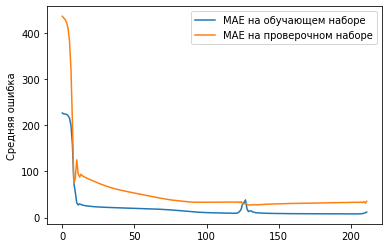

In [ ]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1,
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1,
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [ ]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 6ms/step


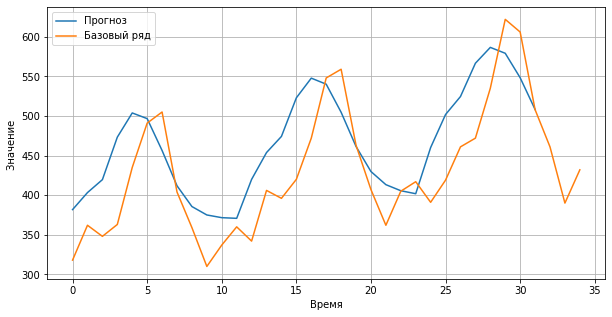

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step],
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

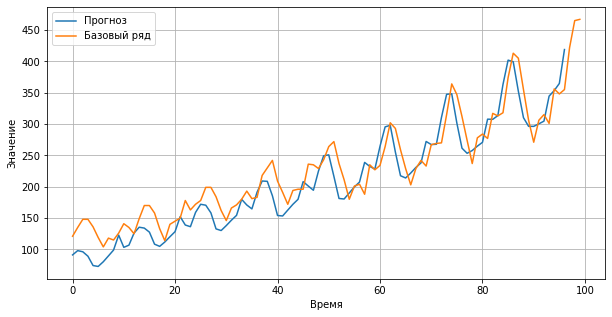

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size],
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 5ms/step - loss: 1648.6764 - mae: 35.6584
train_loss: 514.901123046875, train_m: 18.903940200805664
test_loss: 1648.6763916015625, test_m: 35.65843963623047


**LSTM**

In [ ]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 5s 70ms/step - loss: 56654.8984 - mae: 225.6337 - val_loss: 193064.9531 - val_mae: 432.0705
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 56367.2461 - mae: 225.0266 - val_loss: 192130.1250 - val_mae: 430.9945
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 55513.3789 - mae: 223.3014 - val_loss: 188755.3125 - val_mae: 427.0930
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 52547.5547 - mae: 217.2694 - val_loss: 176235.5312 - val_mae: 412.3155
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 42886.2148 - mae: 196.4771 - val_loss: 134860.8594 - val_mae: 359.2635
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 18337.5078 - mae: 128.5506 - val_loss: 42055.2617 - val_mae: 193.4984
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 1074.8152 - mae: 27.3569 - val_loss: 3860.9958 - val_mae: 46.126

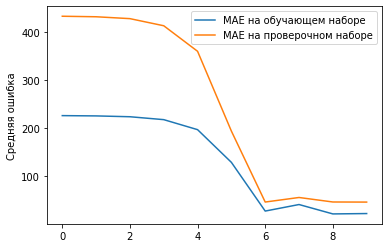

In [ ]:
plt.plot(history_2.history['mae'][:],
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:],
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [ ]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 681.3792 - mae: 20.6457 - val_loss: 4089.8547 - val_mae: 46.9115
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 662.6974 - mae: 20.4064 - val_loss: 3847.5667 - val_mae: 45.8238
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 649.9915 - mae: 19.9916 - val_loss: 4019.2183 - val_mae: 46.5256
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 648.4820 - mae: 20.0318 - val_loss: 3905.9534 - val_mae: 46.0063
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 646.1517 - mae: 19.9604 - val_loss: 3895.6479 - val_mae: 45.9114
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 644.4648 - mae: 19.9270 - val_loss: 3862.7908 - val_mae: 45.7192
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 642.7010 - mae: 19.8748 - val_loss: 3847.1841 - val_mae: 45.6025
Epoch 8/10
13/13 [================

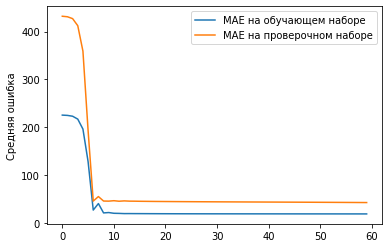

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 609.2464 - mae: 19.3201 - val_loss: 3396.6516 - val_mae: 42.9804
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 608.3246 - mae: 19.3123 - val_loss: 3385.8594 - val_mae: 42.9087
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 607.3693 - mae: 19.3039 - val_loss: 3374.8262 - val_mae: 42.8345
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 606.3783 - mae: 19.2953 - val_loss: 3363.5398 - val_mae: 42.7578
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 605.3488 - mae: 19.2866 - val_loss: 3351.9890 - val_mae: 42.6782
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 604.2776 - mae: 19.2772 - val_loss: 3340.1560 - val_mae: 42.5957
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 603.1619 - mae: 19.2669 - val_loss: 3328.0273 - val_mae: 42.5100
Epoch 8/10
13/13 [================

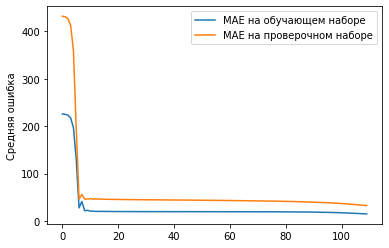

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 320.1438 - mae: 14.3614 - val_loss: 1856.3406 - val_mae: 31.8842
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 304.1711 - mae: 14.0233 - val_loss: 1785.6414 - val_mae: 31.4570
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 288.4160 - mae: 13.6678 - val_loss: 1714.6367 - val_mae: 31.0168
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 273.0528 - mae: 13.2968 - val_loss: 1643.8861 - val_mae: 30.5729
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 258.2589 - mae: 12.9230 - val_loss: 1574.0168 - val_mae: 30.1788
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 244.2023 - mae: 12.5782 - val_loss: 1505.6996 - val_mae: 29.7909
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 231.0315 - mae: 12.2386 - val_loss: 1439.6119 - val_mae: 29.4011
Epoch 8/10
13/13 [================

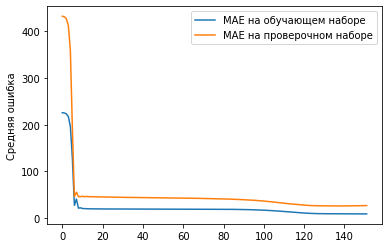

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 134.1667 - mae: 9.0818 - val_loss: 985.2450 - val_mae: 27.0550
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 133.8750 - mae: 9.0725 - val_loss: 991.6836 - val_mae: 27.1471
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 133.5957 - mae: 9.0632 - val_loss: 998.2131 - val_mae: 27.2410
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 133.3275 - mae: 9.0539 - val_loss: 1004.8331 - val_mae: 27.3518
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 133.0696 - mae: 9.0446 - val_loss: 1011.5275 - val_mae: 27.4602
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 132.8220 - mae: 9.0362 - val_loss: 1018.2885 - val_mae: 27.5664
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 132.5831 - mae: 9.0282 - val_loss: 1025.1030 - val_mae: 27.6703
Epoch 2/10
13/13 [==========================

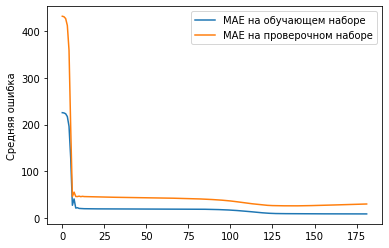

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 128.4066 - mae: 8.8775 - val_loss: 1196.5781 - val_mae: 30.2209
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 128.2670 - mae: 8.8714 - val_loss: 1203.9612 - val_mae: 30.3187
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 128.1287 - mae: 8.8652 - val_loss: 1211.3726 - val_mae: 30.4154
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 127.9913 - mae: 8.8591 - val_loss: 1218.8156 - val_mae: 30.5110
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 127.8554 - mae: 8.8537 - val_loss: 1226.2749 - val_mae: 30.6054
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 127.7204 - mae: 8.8486 - val_loss: 1233.7583 - val_mae: 30.6987
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 127.5864 - mae: 8.8440 - val_loss: 1241.2703 - val_mae: 30.7909
Epoch 2/10
13/13 [=======================

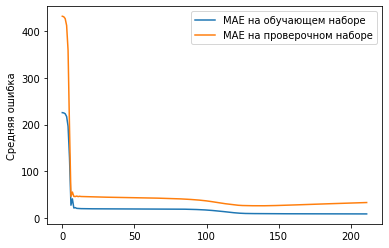

In [ ]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2,
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2,
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [ ]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 4ms/step


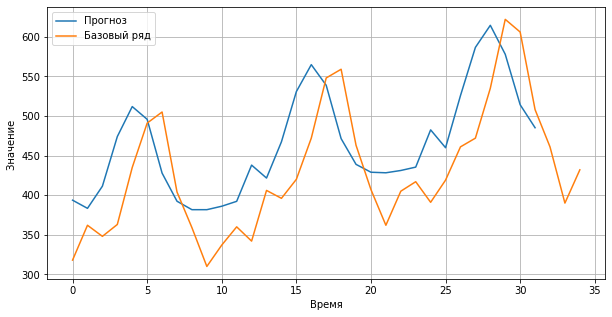

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step],
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

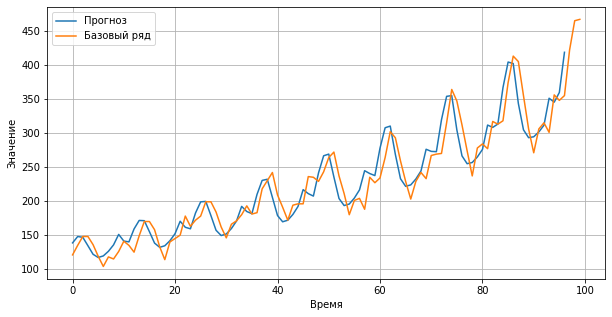

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size],
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 5ms/step - loss: 1427.4086 - mae: 33.1059
train_loss: 102.20609283447266, train_m: 7.863512992858887
test_loss: 1427.4085693359375, test_m: 33.10593032836914


**GRU**

In [ ]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 8
hidden_size = 32
num_iterations = 25
num_epochs = 1
num_preds = 100

In [ ]:
model_3 = Sequential()
model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=True
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 32)             3456      
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 14,023
Trainable params: 14,023
Non-trai

In [ ]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 1s 26ms/step - loss: 56853.4062 - mae: 225.8718 - val_loss: 194767.2812 - val_mae: 434.0093
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 56377.9023 - mae: 224.8519 - val_loss: 193082.6719 - val_mae: 432.1116
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 55939.4609 - mae: 224.1029 - val_loss: 190862.6250 - val_mae: 429.6106
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 54860.1992 - mae: 222.1076 - val_loss: 185811.5000 - val_mae: 423.8743
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 51724.4336 - mae: 216.0402 - val_loss: 172053.8906 - val_mae: 407.8092
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 42740.9258 - mae: 197.1277 - val_loss: 135839.9219 - val_mae: 361.8856
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 21801.9141 - mae: 140.5735 - val_loss: 61253.4336 - val_mae: 23

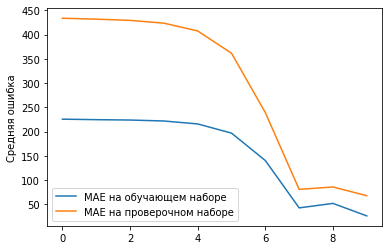

In [ ]:
plt.plot(history_3.history['mae'][:],
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:],
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 809.2034 - mae: 22.9507 - val_loss: 5255.4458 - val_mae: 52.4947
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 744.7654 - mae: 21.6087 - val_loss: 6060.8110 - val_mae: 56.8686
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 724.3716 - mae: 21.2872 - val_loss: 5873.9863 - val_mae: 55.8455
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 729.4957 - mae: 21.4327 - val_loss: 5705.5356 - val_mae: 54.9603
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 713.7480 - mae: 21.1211 - val_loss: 5770.5234 - val_mae: 55.4331
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 710.7604 - mae: 21.1135 - val_loss: 5627.4170 - val_mae: 54.6255
Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 706.1744 - mae: 21.0257 - val_loss: 5567.5273 - val_mae: 54.2886
Epoch 2/10
13/13 [================

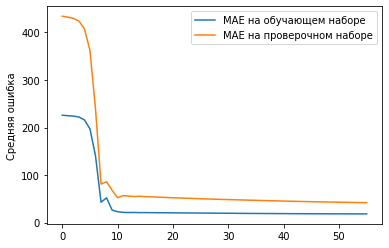

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 559.6446 - mae: 18.3289 - val_loss: 3455.3528 - val_mae: 41.9192
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 557.7109 - mae: 18.2973 - val_loss: 3433.4094 - val_mae: 41.7999
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 555.8405 - mae: 18.2685 - val_loss: 3412.6143 - val_mae: 41.6838
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 554.0296 - mae: 18.2398 - val_loss: 3392.9124 - val_mae: 41.5708
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 552.2751 - mae: 18.2154 - val_loss: 3374.2405 - val_mae: 41.4606
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 550.5730 - mae: 18.1940 - val_loss: 3356.5427 - val_mae: 41.3692
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 548.9202 - mae: 18.1724 - val_loss: 3339.7593 - val_mae: 41.2999
Epoch 8/10
13/13 [================

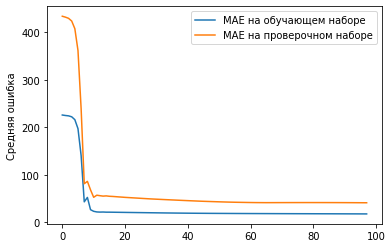

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 499.0351 - mae: 17.4194 - val_loss: 2968.3777 - val_mae: 40.9107
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 497.3680 - mae: 17.3909 - val_loss: 2957.8799 - val_mae: 40.8655
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 495.6461 - mae: 17.3616 - val_loss: 2947.1179 - val_mae: 40.8149
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 493.8641 - mae: 17.3327 - val_loss: 2936.0698 - val_mae: 40.7584
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 492.0158 - mae: 17.3034 - val_loss: 2924.7109 - val_mae: 40.6959
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 490.0945 - mae: 17.2741 - val_loss: 2913.0134 - val_mae: 40.6268
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 488.0937 - mae: 17.2451 - val_loss: 2900.9495 - val_mae: 40.5509
Epoch 8/10
13/13 [================

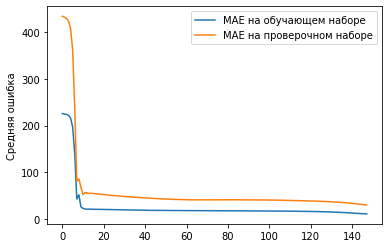

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 181.7526 - mae: 10.8360 - val_loss: 1239.4677 - val_mae: 29.5180
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 174.1533 - mae: 10.5522 - val_loss: 1184.7235 - val_mae: 28.9617
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 167.2813 - mae: 10.2939 - val_loss: 1133.4521 - val_mae: 28.4068
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 161.1388 - mae: 10.0620 - val_loss: 1085.9501 - val_mae: 27.8598
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 155.7144 - mae: 9.8441 - val_loss: 1042.3601 - val_mae: 27.3262
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 150.9736 - mae: 9.6591 - val_loss: 1002.8009 - val_mae: 26.8116
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 146.8754 - mae: 9.5152 - val_loss: 967.2543 - val_mae: 26.3203
Epoch 8/10
13/13 [====================

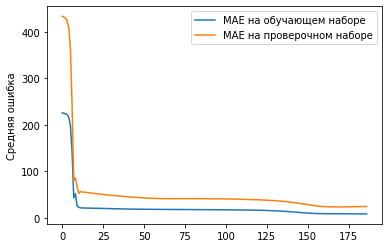

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 117.8247 - mae: 8.4823 - val_loss: 833.0558 - val_mae: 24.6814
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 117.3908 - mae: 8.4650 - val_loss: 839.5709 - val_mae: 24.8098
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 116.9574 - mae: 8.4474 - val_loss: 846.3361 - val_mae: 24.9391
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 116.5237 - mae: 8.4294 - val_loss: 853.3480 - val_mae: 25.0693
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 116.0896 - mae: 8.4113 - val_loss: 860.6618 - val_mae: 25.2013
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 115.6566 - mae: 8.3927 - val_loss: 868.1792 - val_mae: 25.3335
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 115.2231 - mae: 8.3740 - val_loss: 875.9922 - val_mae: 25.4673
Epoch 2/10
13/13 [==============================

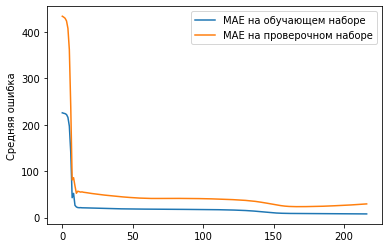

In [ ]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3,
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3,
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [ ]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

5/5 [==============================] - 0s 4ms/step


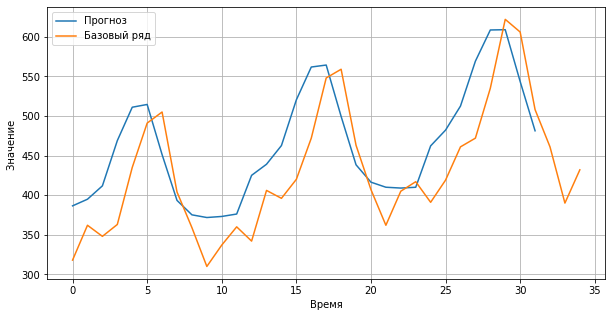

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step],
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

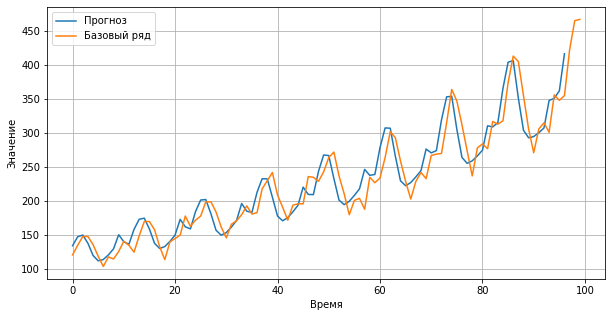

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size],
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')

model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 4ms/step - loss: 1117.9250 - mae: 29.5108
train_loss: 90.78252410888672, train_m: 7.416937351226807
test_loss: 1117.925048828125, test_m: 29.510753631591797


Общий результат

In [ ]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [ ]:
results

,model,train_m,test_m
0,SimpleRNN,18.90,35.66
1,LSTM,7.86,33.11
2,GRU,7.42,29.51


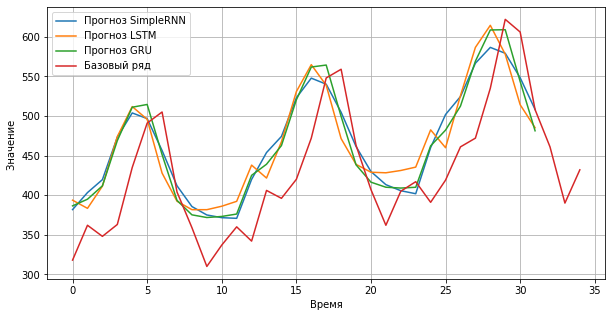

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step],
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step],
         label='Прогноз LSTM')
plt.plot(pred_val_3[future + start: future + start + step],
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

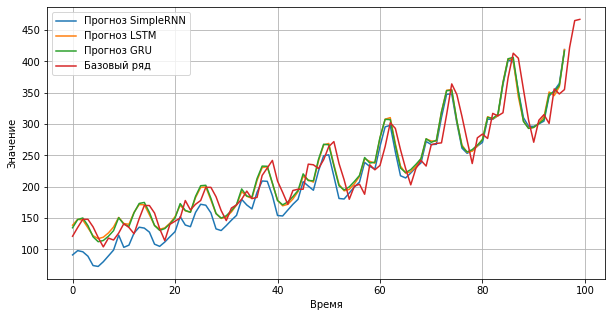

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size],
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size],
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size],
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

**Выводы: **<br>
* чем больше итераций - тем выше качество (25 и правда хватает)
* для данного датасета лучше справился GRU, хотя LSTM сравним с ним по качеству